# Logistic Regression - Optimization Techniques


The goal of this notebook is to learn **how to optimize** a Logistic Regression classifier. We use a large dataset to reveal the benefit of optimization techniques.

We investigate the following two optimization techniques.

- Optimization Algorithms (solvers)
- Dimensionality Reduction

The dimensionality reduction technique can be generalized to other Machine Learning models.

## Dataset: MNIST


We use the MNIST (Modified National Institute of Standards and Technology) dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.


There are 70,000 images. Each image is **grayscale 28 x 28 pixels**, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Thus, each image has **784 features**. 

The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.


## Hardware Specification

The experiments in this notebook are done using a Windows PC with the following specifications:

- Processor Name: Intel Core i7-4770 CPU
- Processor Speed: 3.40 Ghz
- Number of Processors: 1
- Total Number of Cores: 4
- Memory: 16 GB


In [1]:
import warnings
import numpy as np
import pandas as pd
from scipy.io import loadmat
import copy 
%matplotlib inline
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

## Load Data, Create Data Matrix (X) & Target Vector (y)

First load the data and explore the feature names, target names, etc.

We may load the data from a local folder or load it directly from cloud using Scikit-Learn.


In [2]:
# Load the data from the local folder "data"
#mnist = loadmat('data/mnist-original.mat')

# Create the data Matrix X and the target vector y
#X = mnist["data"].T.astype('float32')
#y = mnist["label"][0].astype('int64')


# Load data using Scikit-Learn
mnist = fetch_openml('mnist_784', cache=False)

X = mnist["data"].astype('float32')
y = mnist["target"].astype('int64')


print("\nNo. of Samples: ", X.shape)
print("No. of Labels: ", y.shape)


# Create a deep copy of the Data matrix for using by the PCA
X_original = copy.deepcopy(X)
print("\nNo. of Samples (Copy of X): ", X_original.shape)


No. of Samples:  (70000, 784)
No. of Labels:  (70000,)

No. of Samples (Copy of X):  (70000, 784)


## Display a Random Image

To display a digit, we need to reshape an instance’s feature vector to a 28 x 28 array. 

For displaying we use Matplotlib’s imshow() function.

We see that there are white numbers on a black background, each thickly written just in the middle and they are quite low resolution (28 x 28 pixels).

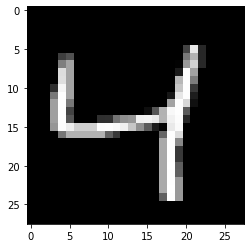

In [3]:
random_digit = X[2]

random_digit_image = random_digit.reshape(28, 28)

plt.imshow(random_digit_image, cmap = 'gray', interpolation="nearest")
#plt.axis("off")
plt.show()

## Visualize A Number With Pixel Values

Let's visualize the above number with its pixel values.

Note that the images are grayscale. Before plotting the grayscale pixel values we need to understand the grayscale image format.

### Grayscale Image Format
A grayscale (or graylevel) image is simply one in which the only colors are shades of gray. The reason for differentiating such images from any other sort of color image is that less information needs to be provided for each pixel. 

In fact a 'gray' color is one in which the red, green and blue components all have equal intensity in RGB space, and so it is only necessary to specify a single intensity value for each pixel, as opposed to the three intensities needed to specify each pixel in a full color image.

For a grayscale images, the pixel value is a single number that represents the **brightness of the pixel**. The most common pixel format is the byte image, where this number is stored as an 8-bit integer giving a range of possible values from 0 to 255. 

Typically **0 is taken to be black, and 255 is taken to be white**. Values in between make up the different shades of gray.

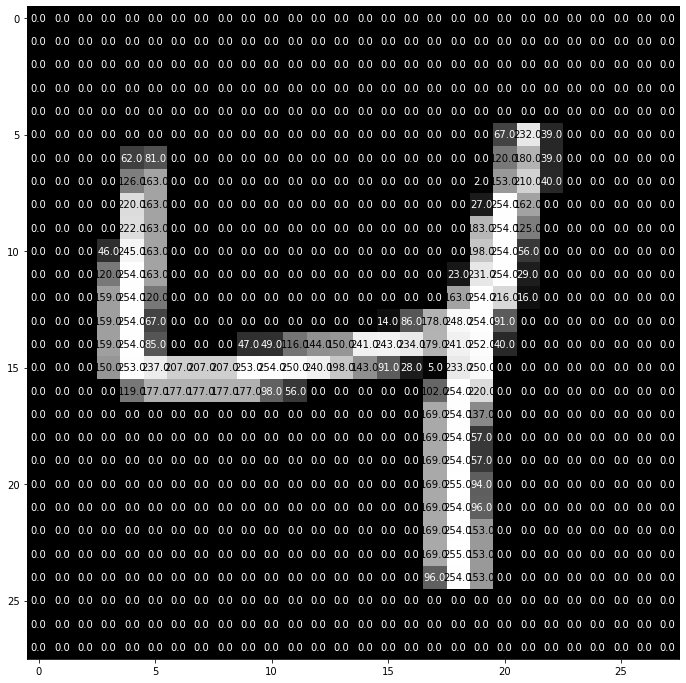

In [4]:
# Visualize a number with its pixel values
def visualize_input(img):
    fig = plt.figure(figsize = (12,12)) 
    img = img.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            plt.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

visualize_input(X[2])

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.

## Data Saling

To avoid big weights that deal with the pixel values from between [0, 255], we scale X down. 

A commonly used range is [0, 1].

In [5]:
X /= 255.0

X.min(), X.max()

(0.0, 1.0)

## Check the Range of Unscaled Data Matrix

The range of the unscaled data matrix X_original should remain unchanged. It will be used by the Principal Component Analysis (PCA) for standardization.

Note that in PCA we prefer standardization over Min-Max scaling, since we are interested in the components that maximize the variance.

In [6]:
X_original.min(), X_original.max()

(0.0, 255.0)

## Create Train and Test Dataset

We use sklearn's train_test_split function to spilt the dataset into training and test subsets. The data is shuffled by default before splitting.

This function splits arrays or matrices into **random** train and test subsets.

For the **reproducibility of the results**, we need to use the same seed for the random number generator. The seed is set by the "random_state" parameter of the split function. 

However, in repeated experiments if we don't want to use the same train and test subsets, then we drop the "random_state" parameter from the funtion.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Optimization using Solvers

Scikit-Learn's LogisticRegression class implements regularized logistic regression using the following algorithms/solvers:

- liblinear library
- newton-cg
- lbfgs
- sag
- saga

These solvers are best understood based on their categories.

Solvers that use **First-order Gradient Descent** Algorithm:
- liblinear
- sag 
- saga

The "sag" and "saga" solvers implement **stochastic gradient descent**, hence they are faster than "liblinear".

Solvers that use **Second-order Gradient Descent** Algorithm:
- newton-cg
- lbfgs

The Second-order Gradient Descent algorithm use the information about the curvature of the space (i.e., the Hessian of the cost function) and thus converge faster. The primary example of this type of algorithm is Newton’s algorithm. Unfortunately, it may be too expensive to compute the Hessian explicitly in Newton's algorithm. 

To remedy this issue, the Quasi-Newton methods are created that iteratively build up an approximation to the Hessian using information gleaned from the gradient vector at each step. The most common method is called BFGS (named after its inventors, Broyden, Fletcher, Goldfarb and Shanno), which updates the approximation. There is a memory efficient version of BFGS wgich is called the limited memory BFGS, or L-BFGS.


We will investigate the performance of these solvers on the MNIST dataset.

Note that the best multi-class classification technique using Logistic Regression is the softmax regression. Only the liblinear solver doesn't support softmax regression. We have to use the one-vs-rest strategy for this solver.


# Optimization using Solvers: Liblinear Library

The solver “liblinear” uses a coordinate descent (CD) algorithm.

The CD algorithm implemented in liblinear cannot learn a true multinomial (multiclass) model. In other words, the liblinear solver does not support softmax regression for multi-class classification.

It uses “one-vs-rest (ovr)” strategy to train separate binary classifiers for all classes. 

## Train the Model Using the liblinear Solver

In [8]:
%%time

log_reg_ovr_liblinear = LogisticRegression(solver='liblinear', multi_class='auto', max_iter=100)

log_reg_ovr_liblinear.fit(X_train, y_train)


Wall time: 1min 4s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Evaluate the liblinear Based Model on Test Data

In [9]:
print("No. of Iterations:", log_reg_ovr_liblinear.n_iter_ )


y_test_predicted = log_reg_ovr_liblinear.predict(X_test)
#print(y_test_predict)

accuracy_score_test_liblinear = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test_liblinear)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

No. of Iterations: [15]

Test Accuracy:  0.9100714285714285

Test Confusion Matrix:
[[1349    1    4    3    2    6   16    0    6    0]
 [   0 1542    7    3    2    7    3    2   14    0]
 [   9   21 1283   24   19    3   16   18   46    4]
 [   5    7   52 1242    1   46    5   18   39   20]
 [   3    4   11    1 1257    3    9    7    8   47]
 [   9    6    8   44   17 1064   28    6   37   12]
 [  11    4   14    2    9   21 1312    3   11    0]
 [   7    9   27    3   18    5    0 1333    8   48]
 [   6   37   13   34   12   45   10    4 1178   29]
 [   6    9   10   22   57   16    1   50    9 1181]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1387
           1       0.94      0.98      0.96      1580
           2       0.90      0.89      0.89      1443
           3       0.90      0.87      0.88      1435
           4       0.90      0.93      0.92      1350
           5       0.88      0.86   

# Optimization using Solvers: SAG

The “sag” solver uses a **Stochastic Average Gradient descent**. It is faster than other solvers for large datasets, when both the number of samples and the number of features are large.

## Train the Model Using the sag Solver¶

In [10]:
%%time
softmax_reg_sag = LogisticRegression(solver='sag', multi_class='multinomial', 
                                     max_iter=100, verbose=1, n_jobs=-1)

softmax_reg_sag.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 142 seconds
Wall time: 2min 22s


c:\program files\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.4min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=1,
                   warm_start=False)

## Evaluate the sag Based Model on Test Data

In [11]:
print("No. of Iterations:", softmax_reg_sag.n_iter_ )


y_test_predicted = softmax_reg_sag.predict(X_test)
#print(y_test_predict)

accuracy_score_test_sag = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test_sag)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

No. of Iterations: [100]

Test Accuracy:  0.9184285714285715

Test Confusion Matrix:
[[1338    0    5    3    1   16   14    3    6    1]
 [   0 1542    6    3    2    7    2    3   13    2]
 [   7   21 1294   21   19    3   16   14   43    5]
 [   5    7   43 1264    0   46    3   15   35   17]
 [   1    3    8    3 1259    4   17   12    5   38]
 [  10    6   11   40   11 1079   21    6   38    9]
 [  15    4   12    2   12   18 1313    3    8    0]
 [   2    6   21    4   13    4    1 1343    5   59]
 [   5   30   11   30    8   42   13    2 1208   19]
 [   6    5    8   15   47   11    1   39   11 1218]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1387
           1       0.95      0.98      0.96      1580
           2       0.91      0.90      0.90      1443
           3       0.91      0.88      0.90      1435
           4       0.92      0.93      0.93      1350
           5       0.88      0.88  

# Optimization using Solvers: SAGA

The “saga” solver is a variant of “sag” that also supports the non-smooth penalty="l1" option. 

This is therefore the solver of choice for **sparse** multinomial logistic regression.

## Train the Model Using the saga Solver¶

In [12]:
%%time
softmax_reg_saga = LogisticRegression(solver='saga', multi_class='multinomial', 
                                      max_iter=100, verbose=1, n_jobs=-1)

softmax_reg_saga.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 351 seconds
Wall time: 5min 51s


c:\program files\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  5.9min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=1,
                   warm_start=False)

## Evaluate the saga Based Model on Test Data

In [13]:
print("No. of Iterations:", softmax_reg_saga.n_iter_ )


y_test_predicted = softmax_reg_saga.predict(X_test)
#print(y_test_predict)

accuracy_score_test_saga = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test_saga)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

No. of Iterations: [100]

Test Accuracy:  0.9175714285714286

Test Confusion Matrix:
[[1338    0    5    3    1   16   14    3    6    1]
 [   0 1541    7    2    2    7    2    4   13    2]
 [   7   22 1294   22   19    3   14   13   44    5]
 [   6    7   44 1261    0   45    3   16   35   18]
 [   1    4    7    2 1259    3   18   12    5   39]
 [  10    4   12   42   11 1077   21    6   38   10]
 [  13    5   12    2   14   20 1310    3    8    0]
 [   2    6   20    4   13    4    1 1345    5   58]
 [   6   31   12   30    9   42   13    2 1205   18]
 [   5    5    7   16   48   11    2   40   11 1216]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1387
           1       0.95      0.98      0.96      1580
           2       0.91      0.90      0.90      1443
           3       0.91      0.88      0.89      1435
           4       0.91      0.93      0.92      1350
           5       0.88      0.87  

# Optimization using Solvers: Newton-CG

The solver “newton-cg” uses implements **second order optimization**.


## Train the Model Using the newton-cg Solver¶

In [14]:
%%time
softmax_reg_newtoncg = LogisticRegression(solver='newton-cg', multi_class='multinomial', 
                                          max_iter=100, verbose=1, n_jobs=-1)

softmax_reg_newtoncg.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Wall time: 8min 56s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.9min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=1,
                   warm_start=False)

## Evaluate the newton-cg Based Model on Test Data

In [15]:
print("No. of Iterations:", softmax_reg_newtoncg.n_iter_ )


y_test_predicted = softmax_reg_newtoncg.predict(X_test)
#print(y_test_predict)

accuracy_score_test_newton_cg = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test_newton_cg)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

No. of Iterations: [26]

Test Accuracy:  0.9182857142857143

Test Confusion Matrix:
[[1338    0    5    3    1   16   14    3    6    1]
 [   0 1542    6    3    2    7    2    3   13    2]
 [   7   20 1296   21   19    3   16   13   43    5]
 [   5    7   44 1262    0   46    3   15   35   18]
 [   2    3    7    3 1259    4   17   12    5   38]
 [  10    6   12   40   11 1079   21    6   37    9]
 [  16    4   12    2   12   18 1313    3    7    0]
 [   2    6   22    4   13    4    1 1342    5   59]
 [   5   30   11   30    8   42   13    2 1208   19]
 [   6    5    8   16   47   11    1   39   11 1217]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1387
           1       0.95      0.98      0.96      1580
           2       0.91      0.90      0.90      1443
           3       0.91      0.88      0.90      1435
           4       0.92      0.93      0.93      1350
           5       0.88      0.88   

# Optimization using Solvers: L-BFGS

The “lbfgs” is an optimization algorithm that approximates the Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm, which belongs to quasi-Newton methods. 

The “lbfgs” solver is recommended for use for small data-sets but for larger datasets its performance might suffer.

## Train the Model Using the lbfgs Solver¶

In [16]:
%%time
softmax_reg_lbfgs = LogisticRegression(solver='lbfgs', multi_class='multinomial', 
                                       max_iter=100, verbose=1, n_jobs=-1)

softmax_reg_lbfgs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   49.0s finished


Wall time: 49.5 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

## Evaluate the lbfgs Based Model on Test Data

In [17]:
print("No. of Iterations:", softmax_reg_lbfgs.n_iter_ )


y_test_predicted = softmax_reg_lbfgs.predict(X_test)
#print(y_test_predict)

accuracy_score_test_lbfgs = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test_lbfgs)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

No. of Iterations: [100]

Test Accuracy:  0.919

Test Confusion Matrix:
[[1344    0    2    3    2   13   15    3    5    0]
 [   0 1541    5    5    2    7    1    3   14    2]
 [   7   18 1295   22   20    4   15   12   45    5]
 [   5    6   50 1257    0   44    4   16   36   17]
 [   1    4    8    2 1263    2   16   11    6   37]
 [   9    5   11   41   11 1082   16    7   37   12]
 [  13    5   13    2   15   18 1311    3    7    0]
 [   3    6   21    4   13    3    1 1349    5   53]
 [   5   32   12   21    9   41   14    1 1214   19]
 [   3    6    7   16   50    9    1   47   12 1210]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1387
           1       0.95      0.98      0.96      1580
           2       0.91      0.90      0.90      1443
           3       0.92      0.88      0.90      1435
           4       0.91      0.94      0.92      1350
           5       0.88      0.88      0.88     

# Summary: Comparison of the Solvers

We observe that the saga solver has the best accuracy.

However, lbfgs is much faster than other solvers and its accuracy is comparable to saga.

Thus, **lbfgs is the best performing solver**.

In [26]:
data = [["liblinear", accuracy_score_test_liblinear, "1 min 4 s"], 
        ["sag", accuracy_score_test_sag, "2 min 22 s"],
        ["saga", accuracy_score_test_saga, "5 min 51s"],
        ["newton-cg", accuracy_score_test_newton_cg, "8 min 56 s"],
        ["lbfgs", accuracy_score_test_lbfgs, "49.5 s"]]
pd.DataFrame(data, columns=["Solver", "Accuracy", "Running-Time"])

,Solver,Accuracy,Running-Time
0,liblinear,0.910071,1 min 4 s
1,sag,0.918429,2 min 22 s
2,saga,0.917571,5 min 51s
3,newton-cg,0.918286,8 min 56 s
4,lbfgs,0.919000,49.5 s


# Optimization Using Dimensionaly Reduction

We can optimize the running-time of the Logistic Regression algorithm by reducing the number of features. Our assumption is that the essence or core content of the data does not span along all dimensions. The technique for reducing the dimension of data is known as dimensionality reduction.

For a gentle introduction to various dimensionality reduction technique, see the notebook "Dimensionality Reduction" in the Github repository.

We will use the **Principle Component Analysis (PCA)** dimensionality reduction technique to project the MNIST dataset (784 features) to a lower dimensional space by retaining maximum variance. 

The goal is to see the improvement in training time due to this dimensionality reduction.

Before we apply the PCA, we need to standardize the data.

Note that in PCA we prefer standardization over Min-Max scaling, since we are interested in the components that maximize the variance. 

Thus, we will use the copy of the data matrix X to standardize it.

## Standardize the Data

PCA is influenced by scale of the data. Thus we need to scale the features of the data before applying PCA. 

For understanding the negative effect of not scaling the data, see the following post:

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py

Note that we fit the scaler on the training set and transform on the training and test set. 

In [19]:
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_original, y, test_size=0.2, random_state=0)


scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train_std)

# Apply transform to both the training set and the test set.
X_train_std = scaler.transform(X_train_std)
X_test_std = scaler.transform(X_test_std)

## Apply PCA

While applying PCA we can set the number of principle components by the "n_components" attribute. But more importantly, we can use this attribute to determine the % of variance we want to retain in the extracted features.

For example, if we set it to 0.95, sklearn will choose the **minimum number of principal components** such that 95% of the variance is retained.

In [20]:
%%time
pca = PCA(n_components=0.95)

pca.fit(X_train_std)

Wall time: 3.16 s


PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

## Number of Principle Components

We can find how many components PCA chose after fitting the model by using the following attribute: n_components_

We will see that 95% of the variance amounts to **315 principal components**.

In [21]:
print("Numberof Principle Components: ", pca.n_components_)  

Numberof Principle Components:  327


## Apply the Mapping (Transform) to both the Training Set and the Test Set

In [22]:
X_train_std = pca.transform(X_train_std)
X_test_std = pca.transform(X_test_std)

## Train The Logistic Regression Model

We use the best performing solver (i.e., lbfgs) to train the model on the PCA transformed data.

In [23]:
%%time

softmax_reg_pca = LogisticRegression(solver='lbfgs', multi_class='multinomial',
                                     max_iter=100, verbose=1, n_jobs=-1)

softmax_reg_pca.fit(X_train_std, y_train_std)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Wall time: 23.2 s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   22.8s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

## Evaluate the Model on the Test Data 



In [24]:
print("No. of Iterations:", softmax_reg_pca.n_iter_ )


y_test_predicted = softmax_reg_pca.predict(X_test_std)
#print(y_test_predict)

accuracy_score_test_PCA_lbfgs = np.mean(y_test_predicted == y_test_std)
print("\nTest Accuracy: ", accuracy_score_test_PCA_lbfgs)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test_std, y_test_predicted))


print("\nClassification Report:")
print(classification_report(y_test_std, y_test_predicted))

No. of Iterations: [100]

Test Accuracy:  0.9191428571428572

Test Confusion Matrix:
[[1347    0    4    1    2   10   16    0    6    1]
 [   0 1537   10    2    2    6    2    3   16    2]
 [   8   23 1289   24   18    5   15   17   38    6]
 [   2    8   51 1264    2   46    2   15   31   14]
 [   1    4    9    2 1262    2   18   10    5   37]
 [  10    6   16   41    7 1085   18    5   35    8]
 [  13    7   12    1   13   16 1317    0    8    0]
 [   3    6   22    6   17    5    0 1340    6   53]
 [   4   36   11   27   10   37    9    3 1212   19]
 [   5    3    6   14   48   10    1   48   11 1215]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1387
           1       0.94      0.97      0.96      1580
           2       0.90      0.89      0.90      1443
           3       0.91      0.88      0.90      1435
           4       0.91      0.93      0.92      1350
           5       0.89      0.88  

# Summary: Comparison of All Optimization Techniques

We observe that after performing PCA (retaining 95% variance), we achieve
- Best accuracy
- Smallest running-time

Thus, the best way to optimize the Logistic Regression model is to use the best performing solver (it would vary depending on the dataset) and by applying dimensionality reduction.

In [27]:
data = [["liblinear", accuracy_score_test_liblinear, "1 min 4 s"], 
        ["sag", accuracy_score_test_sag, "2 min 22 s"],
        ["saga", accuracy_score_test_saga, "5 min 51s"],
        ["newton-cg", accuracy_score_test_newton_cg, "8 min 56 s"],
        ["lbfgs", accuracy_score_test_lbfgs, "49.5 s"],
        ["PCA+lbfgs", accuracy_score_test_PCA_lbfgs, "23.2 s"]]
pd.DataFrame(data, columns=["Solver", "Accuracy", "Running-Time"])

,Solver,Accuracy,Running-Time
0,liblinear,0.910071,1 min 4 s
1,sag,0.918429,2 min 22 s
2,saga,0.917571,5 min 51s
3,newton-cg,0.918286,8 min 56 s
4,lbfgs,0.919000,49.5 s
5,PCA+lbfgs,0.919143,23.2 s
